<a href="https://colab.research.google.com/github/ezrafield/ibm-certificate-final/blob/main/superpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

code from https://www.kaggle.com/code/kmader/superpoint-to-keras/notebook
and idea compare with SIFT


## import

In [48]:
%matplotlib inline
import glob
import numpy as np
import os
import time
import urllib

import cv2
import torch
# Jet colormap for visualization.
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

## Configure setting


In [49]:
weights_path = '/content/drive/MyDrive/colab run files/superpoint/superpoint_v1.pth'

In [50]:
video_path = '/content/drive/MyDrive/colab run files/superpoint/Stockflue Flyaround.mp4'
img_w, img_h = 240, 320
img_scale = 3
max_frame_count = 25

## superpoint net

In [51]:
class SuperPointNet(torch.nn.Module):
  """ Pytorch definition of SuperPoint Network. """
  def __init__(self):
    super(SuperPointNet, self).__init__()
    self.relu = torch.nn.ReLU(inplace=True)
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
    # Shared Encoder.
    self.conv1a = torch.nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
    self.conv1b = torch.nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
    self.conv2a = torch.nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
    self.conv2b = torch.nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
    self.conv3a = torch.nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
    self.conv3b = torch.nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
    self.conv4a = torch.nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
    self.conv4b = torch.nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
    # Detector Head.
    self.convPa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convPb = torch.nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
    # Descriptor Head.
    self.convDa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convDb = torch.nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    """ Forward pass that jointly computes unprocessed point and descriptor
    tensors.
    Input
      x: Image pytorch tensor shaped N x 1 x H x W.
    Output
      semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
      desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
    """
    # Shared Encoder.
    x = self.relu(self.conv1a(x))
    x = self.relu(self.conv1b(x))
    x = self.pool(x)
    x = self.relu(self.conv2a(x))
    x = self.relu(self.conv2b(x))
    x = self.pool(x)
    x = self.relu(self.conv3a(x))
    x = self.relu(self.conv3b(x))
    x = self.pool(x)
    x = self.relu(self.conv4a(x))
    x = self.relu(self.conv4b(x))
    # Detector Head.
    cPa = self.relu(self.convPa(x))
    semi = self.convPb(cPa)
    # Descriptor Head.
    cDa = self.relu(self.convDa(x))
    desc = self.convDb(cDa)
    dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
    desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
    return semi, desc

## Video processing

In [52]:
class VideoStreamer(object):
  """ Class to help process image streams. Three types of possible inputs:"
    1.) USB Webcam.
    2.) A directory of images (files in directory matching 'img_glob').
    3.) A video file, such as an .mp4 or .avi file.
  """
  def __init__(self, basedir, camid, height, width, skip, img_glob):
    self.cap = []
    self.camera = False
    self.video_file = False
    self.listing = []
    self.sizer = [height, width]
    self.i = 0
    self.skip = skip
    self.maxlen = 1000000
    # If the "basedir" string is the word camera, then use a webcam.
    if basedir == "camera/" or basedir == "camera":
      print('==> Processing Webcam Input.')
      self.cap = cv2.VideoCapture(camid)
      self.listing = range(0, self.maxlen)
      self.camera = True
    else:
      # Try to open as a video.
      self.cap = cv2.VideoCapture(basedir)
      lastbit = basedir[-4:len(basedir)]
      if (type(self.cap) == list or not self.cap.isOpened()) and (lastbit == '.mp4'):
        raise IOError('Cannot open movie file')
      elif type(self.cap) != list and self.cap.isOpened() and (lastbit != '.txt'):
        print('==> Processing Video Input.')
        num_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.listing = range(0, num_frames)
        self.listing = self.listing[::self.skip]
        self.camera = True
        self.video_file = True
        self.maxlen = len(self.listing)
      else:
        print('==> Processing Image Directory Input.')
        search = os.path.join(basedir, img_glob)
        self.listing = glob.glob(search)
        self.listing.sort()
        self.listing = self.listing[::self.skip]
        self.maxlen = len(self.listing)
        if self.maxlen == 0:
          raise IOError('No images were found (maybe bad \'--img_glob\' parameter?)')

  def read_image(self, impath, img_size):
    """ Read image as grayscale and resize to img_size.
    Inputs
      impath: Path to input image.
      img_size: (W, H) tuple specifying resize size.
    Returns
      grayim: float32 numpy array sized H x W with values in range [0, 1].
    """
    grayim = cv2.imread(impath, 0)
    if grayim is None:
      raise Exception('Error reading image %s' % impath)
    # Image is resized via opencv.
    interp = cv2.INTER_AREA
    grayim = cv2.resize(grayim, (img_size[1], img_size[0]), interpolation=interp)
    grayim = (grayim.astype('float32') / 255.)
    return grayim

  def next_frame(self):
    """ Return the next frame, and increment internal counter.
    Returns
       image: Next H x W image.
       status: True or False depending whether image was loaded.
    """
    if self.i == self.maxlen:
      return (None, False)
    if self.camera:
      ret, input_image = self.cap.read()
      if ret is False:
        print('VideoStreamer: Cannot get image from camera (maybe bad --camid?)')
        return (None, False)
      if self.video_file:
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.listing[self.i])
      input_image_bgr = cv2.resize(input_image, (self.sizer[1], self.sizer[0]),
                               interpolation=cv2.INTER_AREA)
      input_image = cv2.cvtColor(input_image_bgr, cv2.COLOR_RGB2GRAY)
      input_image = input_image.astype('float')/255.0
    else:
      image_file = self.listing[self.i]
      input_image = self.read_image(image_file, self.sizer)
    # Increment internal counter.
    self.i = self.i + 1
    input_image = input_image.astype('float32')
    return (input_image, input_image_bgr, True)

In [53]:
vs = VideoStreamer(video_path, 0, img_w, img_h, skip=4, img_glob='*.mp4')

==> Processing Video Input.


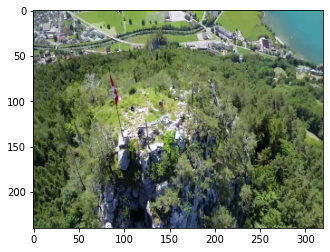

In [54]:
# show a preview frame
plt.imshow(vs.next_frame()[1][:, :, ::-1])

## Load pretrain Network

In [55]:
class SuperPointFrontend(object):
  """ Wrapper around pytorch net to help with pre and post image processing. """
  def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,
               cuda=False):
    self.name = 'SuperPoint'
    self.cuda = cuda
    self.nms_dist = nms_dist
    self.conf_thresh = conf_thresh
    self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
    self.cell = 8 # Size of each output cell. Keep this fixed.
    self.border_remove = 4 # Remove points this close to the border.

    # Load the network in inference mode.
    self.net = SuperPointNet()
    if cuda:
      # Train on GPU, deploy on GPU.
      self.net.load_state_dict(torch.load(weights_path))
      self.net = self.net.cuda()
    else:
      # Train on GPU, deploy on CPU.
      self.net.load_state_dict(torch.load(weights_path,
                               map_location=lambda storage, loc: storage))
    self.net.eval()

  def nms_fast(self, in_corners, H, W, dist_thresh):
    """
    Run a faster approximate Non-Max-Suppression on numpy corners shaped:
      3xN [x_i,y_i,conf_i]^T
  
    Algo summary: Create a grid sized HxW. Assign each corner location a 1, rest
    are zeros. Iterate through all the 1's and convert them either to -1 or 0.
    Suppress points by setting nearby values to 0.
  
    Grid Value Legend:
    -1 : Kept.
     0 : Empty or suppressed.
     1 : To be processed (converted to either kept or supressed).
  
    NOTE: The NMS first rounds points to integers, so NMS distance might not
    be exactly dist_thresh. It also assumes points are within image boundaries.
  
    Inputs
      in_corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
      H - Image height.
      W - Image width.
      dist_thresh - Distance to suppress, measured as an infinty norm distance.
    Returns
      nmsed_corners - 3xN numpy matrix with surviving corners.
      nmsed_inds - N length numpy vector with surviving corner indices.
    """
    grid = np.zeros((H, W)).astype(int) # Track NMS data.
    inds = np.zeros((H, W)).astype(int) # Store indices of points.
    # Sort by confidence and round to nearest int.
    inds1 = np.argsort(-in_corners[2,:])
    corners = in_corners[:,inds1]
    rcorners = corners[:2,:].round().astype(int) # Rounded corners.
    # Check for edge case of 0 or 1 corners.
    if rcorners.shape[1] == 0:
      return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
    if rcorners.shape[1] == 1:
      out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
      return out, np.zeros((1)).astype(int)
    # Initialize the grid.
    for i, rc in enumerate(rcorners.T):
      grid[rcorners[1,i], rcorners[0,i]] = 1
      inds[rcorners[1,i], rcorners[0,i]] = i
    # Pad the border of the grid, so that we can NMS points near the border.
    pad = dist_thresh
    grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
    # Iterate through points, highest to lowest conf, suppress neighborhood.
    count = 0
    for i, rc in enumerate(rcorners.T):
      # Account for top and left padding.
      pt = (rc[0]+pad, rc[1]+pad)
      if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
        grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
        grid[pt[1], pt[0]] = -1
        count += 1
    # Get all surviving -1's and return sorted array of remaining corners.
    keepy, keepx = np.where(grid==-1)
    keepy, keepx = keepy - pad, keepx - pad
    inds_keep = inds[keepy, keepx]
    out = corners[:, inds_keep]
    values = out[-1, :]
    inds2 = np.argsort(-values)
    out = out[:, inds2]
    out_inds = inds1[inds_keep[inds2]]
    return out, out_inds

  def run(self, img):
    """ Process a numpy image to extract points and descriptors.
    Input
      img - HxW numpy float32 input image in range [0,1].
    Output
      corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
      desc - 256xN numpy array of corresponding unit normalized descriptors.
      heatmap - HxW numpy heatmap in range [0,1] of point confidences.
      """
    assert img.ndim == 2, 'Image must be grayscale.'
    assert img.dtype == np.float32, 'Image must be float32.'
    H, W = img.shape[0], img.shape[1]
    inp = img.copy()
    inp = (inp.reshape(1, H, W))
    inp = torch.from_numpy(inp)
    inp = torch.autograd.Variable(inp).view(1, 1, H, W)
    if self.cuda:
      inp = inp.cuda()
    # Forward pass of network.
    outs = self.net.forward(inp)
    semi, coarse_desc = outs[0], outs[1]
    # Convert pytorch -> numpy.
    semi = semi.data.cpu().numpy().squeeze()
    # --- Process points.
    dense = np.exp(semi) # Softmax.
    dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
    # Remove dustbin.
    nodust = dense[:-1, :, :]
    # Reshape to get full resolution heatmap.
    Hc = int(H / self.cell)
    Wc = int(W / self.cell)
    nodust = nodust.transpose(1, 2, 0)
    heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
    heatmap = np.transpose(heatmap, [0, 2, 1, 3])
    heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell])
    xs, ys = np.where(heatmap >= self.conf_thresh) # Confidence threshold.
    if len(xs) == 0:
      return np.zeros((3, 0)), None, None
    pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
    pts[0, :] = ys
    pts[1, :] = xs
    pts[2, :] = heatmap[xs, ys]
    pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
    inds = np.argsort(pts[2,:])
    pts = pts[:,inds[::-1]] # Sort by confidence.
    # Remove points along border.
    bord = self.border_remove
    toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
    toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
    toremove = np.logical_or(toremoveW, toremoveH)
    pts = pts[:, ~toremove]
    # --- Process descriptor.
    D = coarse_desc.shape[1]
    if pts.shape[1] == 0:
      desc = np.zeros((D, 0))
    else:
      # Interpolate into descriptor map using 2D point locations.
      samp_pts = torch.from_numpy(pts[:2, :].copy())
      samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
      samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
      samp_pts = samp_pts.transpose(0, 1).contiguous()
      samp_pts = samp_pts.view(1, 1, -1, 2)
      samp_pts = samp_pts.float()
      if self.cuda:
        samp_pts = samp_pts.cuda()
      desc = torch.nn.functional.grid_sample(coarse_desc, samp_pts)
      desc = desc.data.cpu().numpy().reshape(D, -1)
      desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]
    return pts, desc, heatmap

In [56]:
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,
                      nms_dist=4,
                      conf_thresh=0.015,
                      nn_thresh=0.7,
                      cuda=0)

## Tracking point

In [57]:
class PointTracker(object):
  """ Class to manage a fixed memory of points and descriptors that enables
  sparse optical flow point tracking.
  Internally, the tracker stores a 'tracks' matrix sized M x (2+L), of M
  tracks with maximum length L, where each row corresponds to:
  row_m = [track_id_m, avg_desc_score_m, point_id_0_m, ..., point_id_L-1_m].
  """

  def __init__(self, max_length, nn_thresh):
    if max_length < 2:
      raise ValueError('max_length must be greater than or equal to 2.')
    self.maxl = max_length
    self.nn_thresh = nn_thresh
    self.all_pts = []
    for n in range(self.maxl):
      self.all_pts.append(np.zeros((2, 0)))
    self.last_desc = None
    self.tracks = np.zeros((0, self.maxl+2))
    self.track_count = 0
    self.max_score = 9999

  def nn_match_two_way(self, desc1, desc2, nn_thresh):
    """
    Performs two-way nearest neighbor matching of two sets of descriptors, such
    that the NN match from descriptor A->B must equal the NN match from B->A.
    Inputs:
      desc1 - NxM numpy matrix of N corresponding M-dimensional descriptors.
      desc2 - NxM numpy matrix of N corresponding M-dimensional descriptors.
      nn_thresh - Optional descriptor distance below which is a good match.
    Returns:
      matches - 3xL numpy array, of L matches, where L <= N and each column i is
                a match of two descriptors, d_i in image 1 and d_j' in image 2:
                [d_i index, d_j' index, match_score]^T
    """
    assert desc1.shape[0] == desc2.shape[0]
    if desc1.shape[1] == 0 or desc2.shape[1] == 0:
      return np.zeros((3, 0))
    if nn_thresh < 0.0:
      raise ValueError('\'nn_thresh\' should be non-negative')
    # Compute L2 distance. Easy since vectors are unit normalized.
    dmat = np.dot(desc1.T, desc2)
    dmat = np.sqrt(2-2*np.clip(dmat, -1, 1))
    # Get NN indices and scores.
    idx = np.argmin(dmat, axis=1)
    scores = dmat[np.arange(dmat.shape[0]), idx]
    # Threshold the NN matches.
    keep = scores < nn_thresh
    # Check if nearest neighbor goes both directions and keep those.
    idx2 = np.argmin(dmat, axis=0)
    keep_bi = np.arange(len(idx)) == idx2[idx]
    keep = np.logical_and(keep, keep_bi)
    idx = idx[keep]
    scores = scores[keep]
    # Get the surviving point indices.
    m_idx1 = np.arange(desc1.shape[1])[keep]
    m_idx2 = idx
    # Populate the final 3xN match data structure.
    matches = np.zeros((3, int(keep.sum())))
    matches[0, :] = m_idx1
    matches[1, :] = m_idx2
    matches[2, :] = scores
    return matches

  def get_offsets(self):
    """ Iterate through list of points and accumulate an offset value. Used to
    index the global point IDs into the list of points.
    Returns
      offsets - N length array with integer offset locations.
    """
    # Compute id offsets.
    offsets = []
    offsets.append(0)
    for i in range(len(self.all_pts)-1): # Skip last camera size, not needed.
      offsets.append(self.all_pts[i].shape[1])
    offsets = np.array(offsets)
    offsets = np.cumsum(offsets)
    return offsets

  def update(self, pts, desc):
    """ Add a new set of point and descriptor observations to the tracker.
    Inputs
      pts - 3xN numpy array of 2D point observations.
      desc - DxN numpy array of corresponding D dimensional descriptors.
    """
    if pts is None or desc is None:
      print('PointTracker: Warning, no points were added to tracker.')
      return
    assert pts.shape[1] == desc.shape[1]
    # Initialize last_desc.
    if self.last_desc is None:
      self.last_desc = np.zeros((desc.shape[0], 0))
    # Remove oldest points, store its size to update ids later.
    remove_size = self.all_pts[0].shape[1]
    self.all_pts.pop(0)
    self.all_pts.append(pts)
    # Remove oldest point in track.
    self.tracks = np.delete(self.tracks, 2, axis=1)
    # Update track offsets.
    for i in range(2, self.tracks.shape[1]):
      self.tracks[:, i] -= remove_size
    self.tracks[:, 2:][self.tracks[:, 2:] < -1] = -1
    offsets = self.get_offsets()
    # Add a new -1 column.
    self.tracks = np.hstack((self.tracks, -1*np.ones((self.tracks.shape[0], 1))))
    # Try to append to existing tracks.
    matched = np.zeros((pts.shape[1])).astype(bool)
    matches = self.nn_match_two_way(self.last_desc, desc, self.nn_thresh)
    for match in matches.T:
      # Add a new point to it's matched track.
      id1 = int(match[0]) + offsets[-2]
      id2 = int(match[1]) + offsets[-1]
      found = np.argwhere(self.tracks[:, -2] == id1)
      if found.shape[0] > 0:
        matched[int(match[1])] = True
        row = int(found)
        self.tracks[row, -1] = id2
        if self.tracks[row, 1] == self.max_score:
          # Initialize track score.
          self.tracks[row, 1] = match[2]
        else:
          # Update track score with running average.
          # NOTE(dd): this running average can contain scores from old matches
          #           not contained in last max_length track points.
          track_len = (self.tracks[row, 2:] != -1).sum() - 1.
          frac = 1. / float(track_len)
          self.tracks[row, 1] = (1.-frac)*self.tracks[row, 1] + frac*match[2]
    # Add unmatched tracks.
    new_ids = np.arange(pts.shape[1]) + offsets[-1]
    new_ids = new_ids[~matched]
    new_tracks = -1*np.ones((new_ids.shape[0], self.maxl + 2))
    new_tracks[:, -1] = new_ids
    new_num = new_ids.shape[0]
    new_trackids = self.track_count + np.arange(new_num)
    new_tracks[:, 0] = new_trackids
    new_tracks[:, 1] = self.max_score*np.ones(new_ids.shape[0])
    self.tracks = np.vstack((self.tracks, new_tracks))
    self.track_count += new_num # Update the track count.
    # Remove empty tracks.
    keep_rows = np.any(self.tracks[:, 2:] >= 0, axis=1)
    self.tracks = self.tracks[keep_rows, :]
    # Store the last descriptors.
    self.last_desc = desc.copy()
    return

  def get_tracks(self, min_length):
    """ Retrieve point tracks of a given minimum length.
    Input
      min_length - integer >= 1 with minimum track length
    Output
      returned_tracks - M x (2+L) sized matrix storing track indices, where
        M is the number of tracks and L is the maximum track length.
    """
    if min_length < 1:
      raise ValueError('\'min_length\' too small.')
    valid = np.ones((self.tracks.shape[0])).astype(bool)
    good_len = np.sum(self.tracks[:, 2:] != -1, axis=1) >= min_length
    # Remove tracks which do not have an observation in most recent frame.
    not_headless = (self.tracks[:, -1] != -1)
    keepers = np.logical_and.reduce((valid, good_len, not_headless))
    returned_tracks = self.tracks[keepers, :].copy()
    return returned_tracks

  def draw_tracks(self, out, tracks):
    """ Visualize tracks all overlayed on a single image.
    Inputs
      out - numpy uint8 image sized HxWx3 upon which tracks are overlayed.
      tracks - M x (2+L) sized matrix storing track info.
    """
    # Store the number of points per camera.
    pts_mem = self.all_pts
    N = len(pts_mem) # Number of cameras/images.
    # Get offset ids needed to reference into pts_mem.
    offsets = self.get_offsets()
    # Width of track and point circles to be drawn.
    stroke = 1
    # Iterate through each track and draw it.
    for track in tracks:
      clr = myjet[int(np.clip(np.floor(track[1]*10), 0, 9)), :]*255
      for i in range(N-1):
        if track[i+2] == -1 or track[i+3] == -1:
          continue
        offset1 = offsets[i]
        offset2 = offsets[i+1]
        idx1 = int(track[i+2]-offset1)
        idx2 = int(track[i+3]-offset2)
        pt1 = pts_mem[i][:2, idx1]
        pt2 = pts_mem[i+1][:2, idx2]
        p1 = (int(round(pt1[0])), int(round(pt1[1])))
        p2 = (int(round(pt2[0])), int(round(pt2[1])))
        cv2.line(out, p1, p2, clr, thickness=stroke, lineType=16)
        # Draw end points of each track.
        if i == N-2:
          clr2 = (255, 0, 0)
          cv2.circle(out, p2, stroke, clr2, -1, lineType=16)

In [58]:
# This class helps merge consecutive point matches into tracks.
tracker = PointTracker(10, nn_thresh=fe.nn_thresh)

In [59]:
# Font parameters for visualizaton.
font = cv2.FONT_HERSHEY_DUPLEX
font_clr = (255, 255, 255)
font_pt = (4, 12)
font_sc = 0.4

## Test Run

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


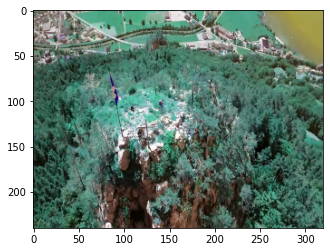

In [60]:
fig, ax1 = plt.subplots(1, 1, figsize = (12, 4))
# Get a new image.
img, img_bgr, status = vs.next_frame()
ax1.imshow(img_bgr)
pts, desc, heatmap = fe.run(img)

## Extract Weight

In [61]:
net_state = fe.net.state_dict()
print(fe.net)

SuperPointNet(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d

## Test Result

In [62]:
H, W = img.shape[0], img.shape[1]
inp = img.copy()
inp = (inp.reshape(1, H, W))
inp = torch.from_numpy(inp)
inp = torch.autograd.Variable(inp).view(1, 1, H, W)
# Forward pass of network.
outs = fe.net.forward(inp)
semi_out, desc_out = outs[0].cpu().detach().numpy(), outs[1].cpu().detach().numpy()

print(semi_out.shape, desc_out.shape)

(1, 65, 30, 40) (1, 256, 30, 40)


In [63]:
t_to_k = lambda x: x.swapaxes(1, 3).swapaxes(2, 3)
print('Semi:', 'Mean Abs Torch Output', np.mean(np.abs(semi_out)), 'Desc:', 'Mean Abs Torch Output', np.mean(np.abs(desc_out)))

Semi: Mean Abs Torch Output 8.465367 Desc: Mean Abs Torch Output 0.04990571


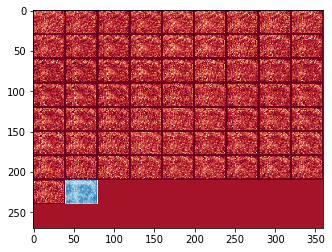

In [64]:
from skimage.util import montage as montage2d
pltargs = dict(cmap = 'RdBu', vmin = -10, vmax = 10)
plt.imshow(montage2d(semi_out[0]), **pltargs)


## Model post processing

In [65]:
H, W = img.shape[0], img.shape[1]
inp = img.copy()
inp = (inp.reshape(1, H, W))
inp = torch.from_numpy(inp)
inp = torch.autograd.Variable(inp).view(1, 1, H, W)
# Forward pass of network.
outs = fe.net.forward(inp)
semi, coarse_desc = outs[0], outs[1]
# Convert pytorch -> numpy.
semi = semi.data.cpu().numpy().squeeze()
# --- Process points.
dense = np.exp(semi) # Softmax.
dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
# Remove dustbin.
nodust = dense[:-1, :, :]
# Reshape to get full resolution heatmap.
Hc = int(H / fe.cell)
Wc = int(W / fe.cell)
nodust = nodust.transpose(1, 2, 0)
heatmap = np.reshape(nodust, [Hc, Wc, fe.cell, fe.cell])
heatmap = np.transpose(heatmap, [0, 2, 1, 3])
heatmap = np.reshape(heatmap, [Hc*fe.cell, Wc*fe.cell])
xs, ys = np.where(heatmap >= fe.conf_thresh) # Confidence threshold.

pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
pts[0, :] = ys
pts[1, :] = xs
pts[2, :] = heatmap[xs, ys]
pts, _ = fe.nms_fast(pts, H, W, dist_thresh=fe.nms_dist) # Apply NMS.
inds = np.argsort(pts[2,:])
pts = pts[:,inds[::-1]] # Sort by confidence.
# Remove points along border.
bord = fe.border_remove
toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
toremove = np.logical_or(toremoveW, toremoveH)
pts = pts[:, ~toremove]
# --- Process descriptor.
D = coarse_desc.shape[1]
if pts.shape[1] == 0:
    desc = np.zeros((D, 0))
else:
    # Interpolate into descriptor map using 2D point locations.
    samp_pts = torch.from_numpy(pts[:2, :].copy())
    samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
    samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
    samp_pts = samp_pts.transpose(0, 1).contiguous()
    samp_pts = samp_pts.view(1, 1, -1, 2)
    samp_pts = samp_pts.float()
    desc = torch.nn.functional.grid_sample(coarse_desc, samp_pts, align_corners = True)
    desc = desc.data.cpu().numpy().reshape(D, -1)
    desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

# Result

In [66]:
%%time
torch_outputs = fe.run(img)

CPU times: user 292 ms, sys: 29.2 ms, total: 321 ms
Wall time: 319 ms


In [67]:
myjet = np.array([[0.        , 0.        , 0.5       ],
                  [0.        , 0.        , 0.99910873],
                  [0.        , 0.37843137, 1.        ],
                  [0.        , 0.83333333, 1.        ],
                  [0.30044276, 1.        , 0.66729918],
                  [0.66729918, 1.        , 0.30044276],
                  [1.        , 0.90123457, 0.        ],
                  [1.        , 0.48002905, 0.        ],
                  [0.99910873, 0.07334786, 0.        ],
                  [0.5       , 0.        , 0.        ]])

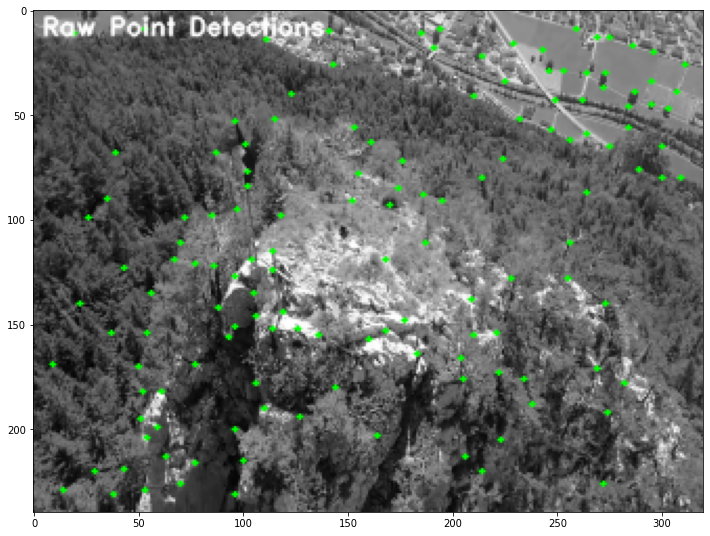

Processed image 26 (net+post_process: 1.24 FPS, total: 0.38 FPS).


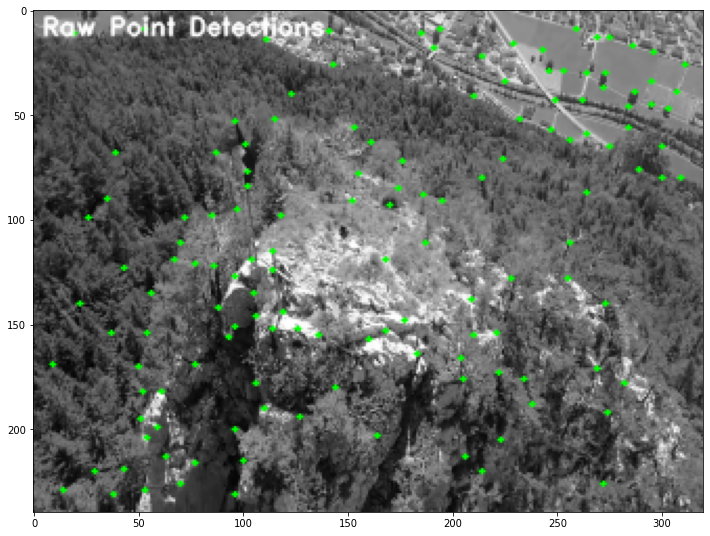

In [68]:
fig, ax1 = plt.subplots(1, 1, figsize = (12, 16))
while True:
    start = time.time()

    # Get a new image.
    img, img_bgr, status = vs.next_frame()
    if status is False:
        break

    # Get points and descriptors.
    start1 = time.time()
    pts, desc, heatmap = fe.run(img)
    end1 = time.time()

    # Add points and descriptors to the tracker.
    # tracker.update(pts, desc)

    # # Get tracks for points which were match successfully across all frames.
    # tracks = tracker.get_tracks(2)

    # # Primary output - Show point tracks overlayed on top of input image.
    # out1 = img_bgr # use a color image
    # # tracks[:, 1] /= float(fe.nn_thresh) # Normalize track scores to [0,1].
    # # tracker.draw_tracks(out1, tracks)
    # cv2.putText(out1, 'Point Tracks', font_pt, font, font_sc, font_clr, lineType=16)

    # Extra output -- Show current point detections.
    out2 = (np.dstack((img, img, img)) * 255.).astype('uint8')
    for pt in pts.T:
        pt1 = (int(round(pt[0])), int(round(pt[1])))
        cv2.circle(out2, pt1, 1, (0, 255, 0), -1, lineType=16)
    cv2.putText(out2, 'Raw Point Detections', font_pt, font, font_sc, font_clr, lineType=16)

    # Extra output -- Show the point confidence heatmap.
    # if heatmap is not None:
    #     min_conf = 0.001
    #     heatmap[heatmap < min_conf] = min_conf
    #     heatmap = -np.log(heatmap)
    #     heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + .00001)
    #     out3 = myjet[np.round(np.clip(heatmap*10, 0, 9)).astype('int'), :]
    #     out3 = (out3*255).astype('uint8')
    # else:
    #     out3 = np.zeros_like(out2)
    # cv2.putText(out3, 'Raw Point Confidences', font_pt, font, font_sc, font_clr, lineType=16)

    # Resize final output.
    # out = np.hstack((out1, out2, out3))
    # out = cv2.resize(out, (3*img_scale*img_w, img_scale*img_h))

    # Display visualization image to screen.
    clear_output()
    ax1.imshow(out2[:, :, ::-1])
    display(fig)

    out_file = 'frame_%05d.png' % vs.i
    cv2.imwrite(out_file, out2)

    end = time.time()
    net_t = (1./ float(end1 - start))
    total_t = (1./ float(end - start))
    print('Processed image %d (net+post_process: %.2f FPS, total: %.2f FPS).'\
        % (vs.i, net_t, total_t))
    if vs.i>max_frame_count:
        break
cv2.destroyAllWindows()

## make gif, show image


In [69]:
!pip install ffmpeg
!sudo apt install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [70]:
# import matplotlib.animation as animation
# Writer = animation.writers['imagemagick']
# writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

# from skimage.io import imread
# all_pngs = sorted(glob.glob('*.png'))

In [71]:
# from tqdm import tqdm

# ims = []
# plt.close('all')
# fig, ax1 = plt.subplots(1,1, figsize = (3*img_w/20, img_h/20))
# f_img = imread(all_pngs[0])
# c_aximg = ax1.imshow(f_img, animated = True)
# ax1.axis('off')
# plt.tight_layout()
# def update_image(frame):
#     if frame>0:
#         r_img = imread(all_pngs[frame])
#     else:
#         r_img = f_img
#     c_aximg.set_array(r_img)
#     return c_aximg,

# im_ani = animation.FuncAnimation(fig, 
#                                  update_image, 
#                                  frames = range(len(all_pngs)),
#                                  interval=200, repeat_delay=300,
#                                 blit=True)

In [72]:
# im_ani.save('out.gif', writer=writer)

## Compare with SIFT

In [73]:
from google.colab.patches import cv2_imshow

req = urllib.request.urlopen('https://blogger.googleusercontent.com/img/a/AVvXsEiEa59UzuBSn-hxboWjuJvUNDrimm0ZmlW-FxGDhUS9mVhPSqSkPwXUqSji0yYK7ZEO4nFhYdJH7ACSc4rL6JRpIBwrTkfLo9BKAsmH7__gUivEKhukGuQ4eKeJ2-1ltqyceOk5MDvvLFlA9RDz_UnTX-wXDaoCTjhXBNbiEGYyIZlURFoRdtMkx3R14Q')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img1 = cv2.imdecode(arr, -1)

# im = cv2.imread("/content/image input.png", 1)

# img1 = vs.next_frame()[1][:, :, ::-1]
# plt.show(img1)
# img_w, img_h = 240, 320

### - SIFT function

In [74]:
def siftresult(img, show = True):
  img1 = img.copy()
  sift = cv2.SIFT_create()
  keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
  img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
  img2=cv2.drawKeypoints(img1, keypoints_1, 0, (0, 255, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
  print("number keypoint of SIFT:" + str(len(keypoints_1)))
  if show == True:
    cv2_imshow(img2)
  return img2

### - Superpoint function


In [75]:
def superpointresult(img, show = True):
    img1 = img.copy()
    img_w, img_h = img.shape[1], img.shape[0]
    img1 = cv2.resize(img1, (img_w, img_h),
                               interpolation=cv2.INTER_AREA)
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img1 = img1.astype('float32')/255.0

    pts, desc, heatmap = fe.run(img1)
    print("number keypoint of superpoint:" + str(len(pts[0])))

    out2 = (np.dstack((img1, img1, img1)) * 255.).astype('uint8')
    for pt in pts.T:
      pt1 = (int(round(pt[0])), int(round(pt[1])))
      cv2.circle(out2, pt1, 3, (0, 255, 0), -1)
    
    out2 = cv2.resize(out2, (img_w, img_h),
                               interpolation=cv2.INTER_AREA)
    if show == True:
      cv2_imshow(out2)
    return out2


### Compare function

In [76]:
def comparesiftvssuperpoint(img):
  localsift = siftresult(img = img, show = False)
  localsuperpoint = superpointresult(img = img, show = False)
  plt.figure(figsize=(60, 20))
  plt.subplot(131), plt.imshow(img)
  plt.title("Original"), plt.xticks([]), plt.yticks([])
  plt.subplot(132), plt.imshow(localsift)
  plt.title("SIFT"), plt.xticks([]), plt.yticks([])
  plt.subplot(133), plt.imshow(localsuperpoint)
  plt.title("Superpoint"), plt.xticks([]), plt.yticks([])
  plt.show()

### Compare

In [77]:
# localsift = siftresult(img = img1, show = True)

In [78]:
# localsuperpoint = superpointresult(img = img1, show = True)

number keypoint of SIFT:11041
number keypoint of superpoint:2616


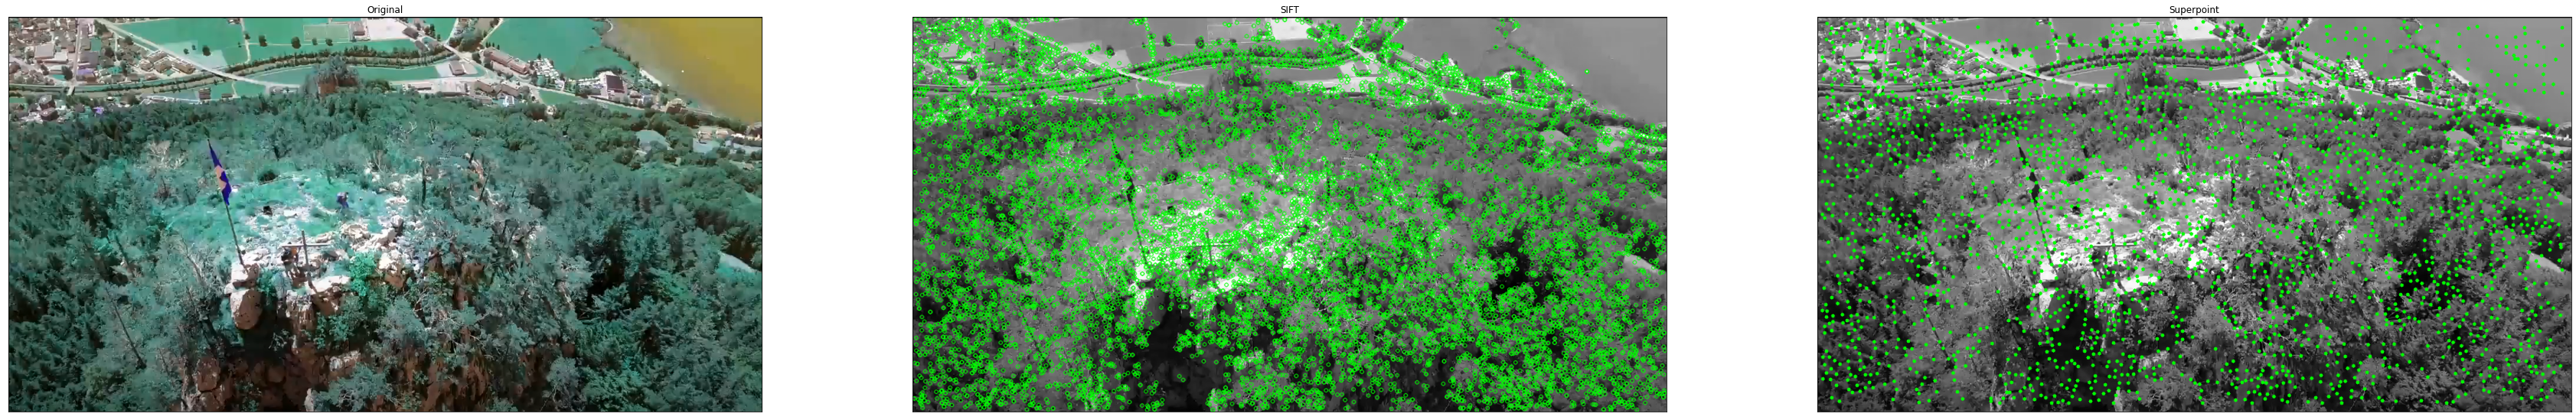

In [79]:
comparesiftvssuperpoint(img1)

# Other example

number keypoint of SIFT:1151
number keypoint of superpoint:483


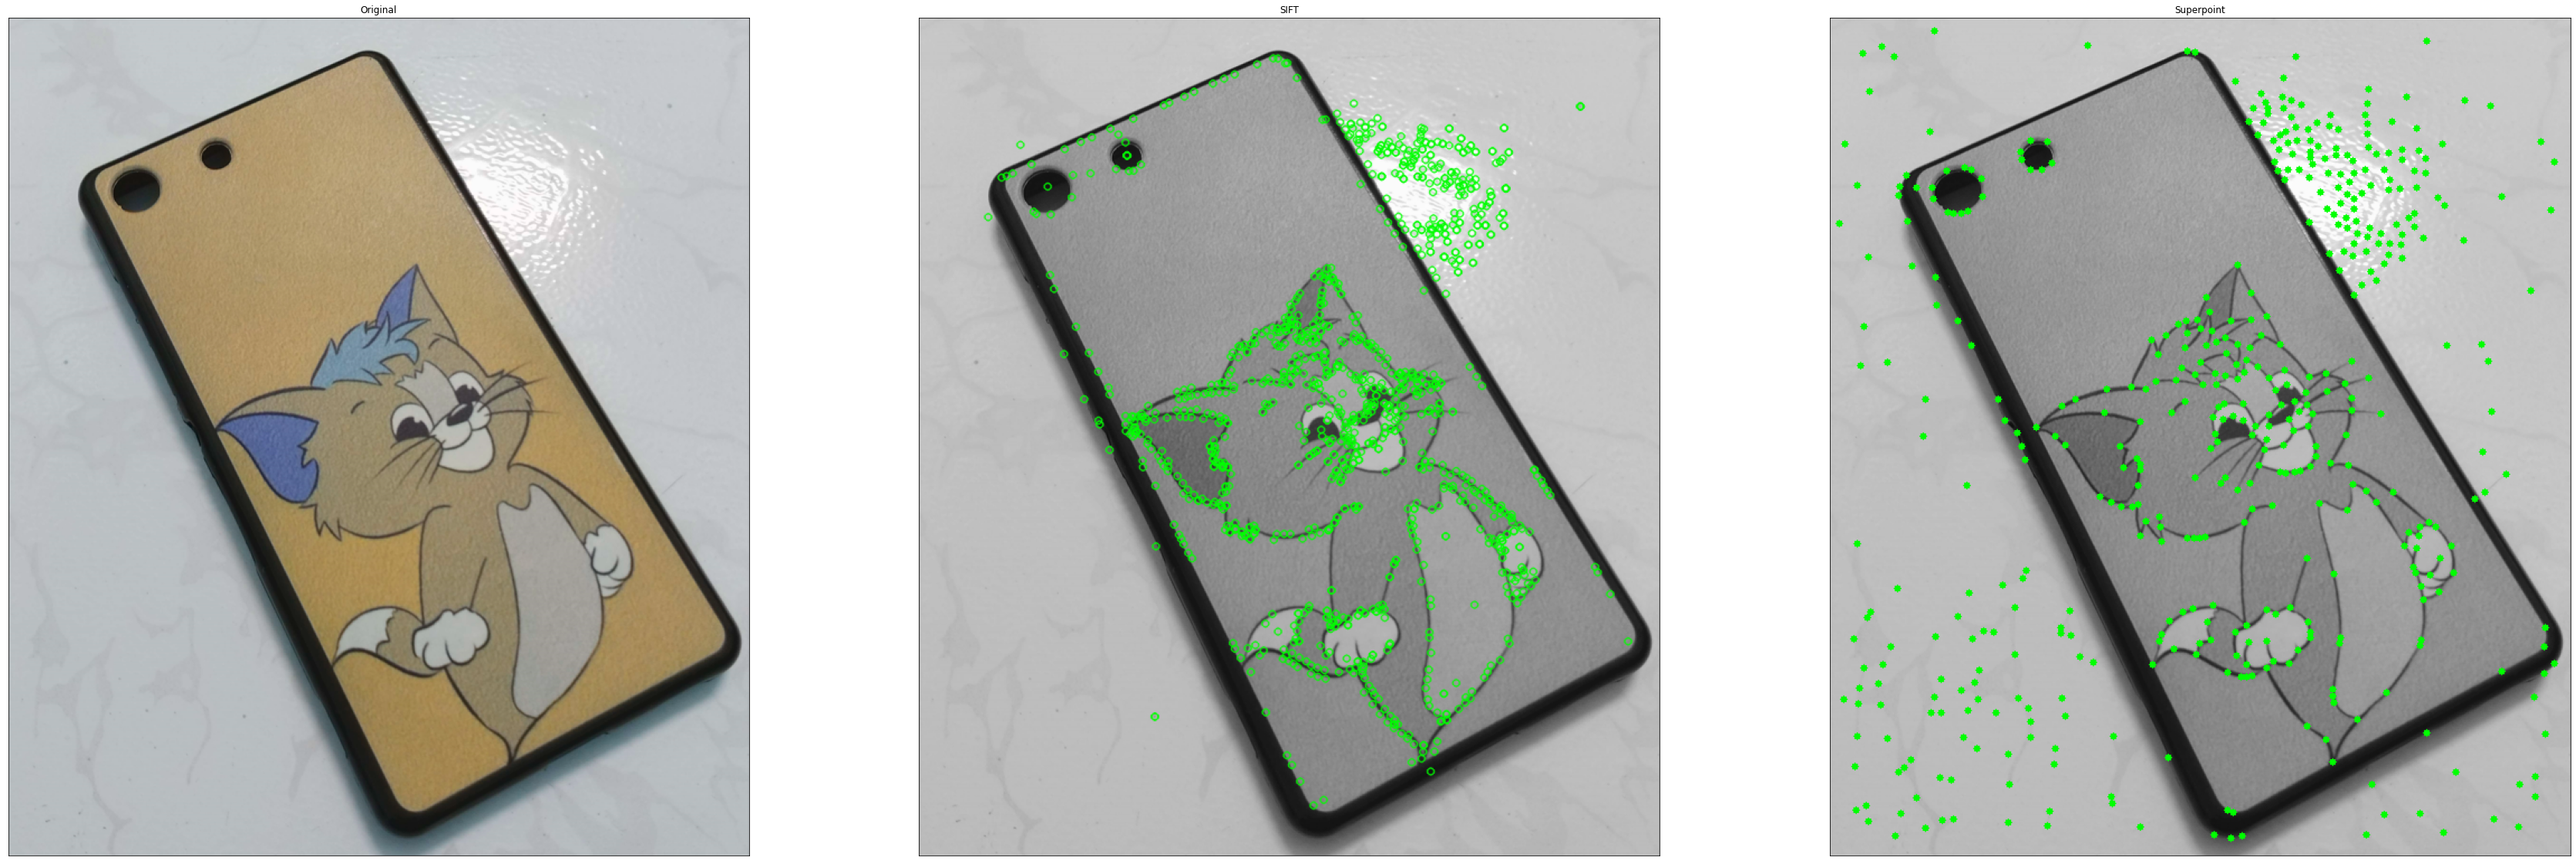

In [80]:
req = urllib.request.urlopen('https://blogger.googleusercontent.com/img/a/AVvXsEhnIBHGDVBtKNb7F23-n-0e7-o-7-CwiLargbjA_dNaBjz3MPoXlPDb6z1fXRPqrezmex89nlapP3ja_udOk4e6_12Y4ya2-YY9g2pV2IvREOoFDhQGnOTvf_UfoKJKbJ7ibSwmf5qiWrlWNjLAb6qhMMf6r0LfUskDJHWPbJwKxg6h2bJCS1WVbI_JCA')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img1 = cv2.imdecode(arr, -1)

comparesiftvssuperpoint(img1)

# Superpoint matching

## pts, desc superpoint function

In [81]:
def superpointdesc(img):
    img1 = img.copy()
    img_w, img_h = img.shape[1], img.shape[0]
    img1 = cv2.resize(img1, (img_w, img_h),
                               interpolation=cv2.INTER_AREA)
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img1 = img1.astype('float32')/255.0

    pts, desc, heatmap = fe.run(img1)

    sppt2 = []
    for pt in pts.T:
      pt1 = (int(round(pt[0])), int(round(pt[1])))
      sppt2.append(pt1)

    desc2 = desc.T
    return sppt2, desc2

In [82]:
# sppt1, spdesc1 = superpointdesc(img = img1)

## SIFT matching class (+ return image )

In [90]:
class RotateMatrix2D:
    def __init__(self, ImageInput1, ImageInput2 = False, degree = 0):
        # image, width, height, MatrixOutput, view
        SIZE = ImageInput1.shape
        self.W, self.H = SIZE[0], SIZE[1]
        self.SIZE = SIZE[:2]
        self.degree = degree
        self.img1 = ImageInput1
        self.img2 = ImageInput2

    #rotate
    def rotateImage(self, degree = 0, viewMatrixRotate = False):
    # quay hình img1 (ảnh gốc)
    # Input: 
    #  - degree : góc quay (theo chiều kim đồng hồ)
    #  - viewMatrixRotate : hiển thị matrix biểu diễn quay không (để so sánh kết quả model)
    # Output: img2 : ảnh sau quay (dạng opencv numpy array)
        if degree == 0:
          degree = self.degree
        height, width = self.SIZE[:2]
        center = (width / 2, height / 2)
        MatrixRotate = cv2.getRotationMatrix2D(center=center, angle= degree, scale=1)
        img2 = cv2.warpAffine(self.img1, MatrixRotate, self.SIZE)
        img2 = cv2.resize(img2, self.SIZE, interpolation=cv2.INTER_AREA)
        if viewMatrixRotate == True:
          print(MatrixRotate)
        return img2

    #SIFT
    def sift(self, img1, img2, view = True):
      # SIFT agorithm cho 2 ảnh
      # Input:
      # - img1, img2 : 2 ảnh cần xét (dạng opencv numpy array)
      # - show : hiện thị biểu diễn 5 match đầu của kết quả SIFT để dễ hình dung
      # Output: 
      # - matches : tập mã hóa match 2 ảnh
      # - keypoints_1, keypoints_2 : tập các đầu mút của tập match ở ảnh 1, ảnh 2
        sift = cv2.SIFT_create()
        keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
        keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

        # feature matching
        bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

        matches = bf.match(descriptors_1, descriptors_2)
        matches = sorted(matches, key=lambda x: x.distance)

        img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:10], img2, flags=2)
        if view == True:
            plt.imshow(img3)
            plt.show()

        return matches, keypoints_1, keypoints_2, img3

    #keypoint coordinate
    def siftKeypointCoord(self, siftResult, numberCheckExample = 0):
      # tìm tọa độ các điểm được match (giải mã matches)
      # Input:
      # - siftResult: kết quả SIFT (đúng form theo method sift trên)
      # - numberCheckExample: hiện 1 vài phần tử đầu tiên để check
      # Output:
      # - list_kp1, list_kp2: tọa độ các điểm đầu mút match tương ứng
        # Initialize lists
        list_kp1 = []
        list_kp2 = []
        matches, keypoints_1, keypoints_2 = siftResult[0], siftResult[1], siftResult[2]
        # For each match...
        for mat in matches:

            # Get the matching keypoints for each of the images
            img1_idx = mat.queryIdx
            img2_idx = mat.trainIdx

            # x - columns
            # y - rows
            # Get the coordinates
            (x1, y1) = keypoints_1[img1_idx].pt
            (x2, y2) = keypoints_2[img2_idx].pt

            # Append to each list

            if (x1, y1) in list_kp1:
                continue
            list_kp1.append((x1, y1))
            list_kp2.append((x2, y2))

        if numberCheckExample > 0:
            list_sorted_matches_pt = [[list_kp1[i], list_kp2[i]] for i in range(len(list_kp1))]
            print(len(list_sorted_matches_pt))
            print(list_kp1[:numberCheckExample])
            print(list_kp2[:numberCheckExample])

        return list_kp1, list_kp2

    # find matrix rotate (matrix homographic)
    def findMatrixRotateSIFT(self, image1, image2, view = True):
      # tìm matrix quay của 2 ảnh
      # Input:
      # - image1, image2: 2 ảnh cần xét
      # - view: hiển thị ảnh kết quả của algorithm
      # Output:
      # - matrix: matrix quay nhận dạng từ algorithm 
        img2v = image2.copy()
        siftResult = self.sift(img1 = image1, img2 = image2, view = False)
        list_kp1, list_kp2 = self.siftKeypointCoord(siftResult = siftResult, numberCheckExample= 0)

        pts1 = np.float32(list_kp1[:4])
        pts2 = np.float32(list_kp2[:4])

        matrix = cv2.getPerspectiveTransform(pts2, pts1)
        imgOutput = cv2.warpPerspective(img2v, matrix, (self.W, self.H), flags=cv2.INTER_LINEAR)
        if view == True:
            plt.imshow(imgOutput)
            plt.show()
        elif view == False:
            print(matrix)
        
        return matrix, imgOutput

    # Harris Corner Detector
    def Harriscorner(self, image1, view = True):
        img1 = image1.copy()
        gray = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
        gray = np.float32(gray)
        dst = cv2.cornerHarris(gray,2,3,0.04)
        """ cornerHarris	(	
          InputArray 	src,
          int 	ksize,
          int 	blockSize,
          float 	k [, dst[, borderType]
          )	
        """ 

        dst = cv2.dilate(dst,None) # làm loan màu, tác dụng như gauss
        # Threshold
        if view == True:
            img2 = img1.copy()
            img2[dst>0.01*dst.max()]=[0,0,255]

            from google.colab.patches import cv2_imshow
            cv2_imshow(img2)

        tableinit = np.zeros(img1.shape[:2])
        tableinit[dst > 0.01*dst.max()] = 1
        ind = np.argwhere(tableinit == 1)

        # return dst[dst>0.01*dst.max()], img2, dst, 0.01*dst.max()
        return ind

    def findMatrixRotate(self, image, list_kp1, list_kp2, view = True):
      # tìm matrix quay của 2 list keypoint
      # Input:
      # - image: ảnh cần xét
      # - list_kp1, list_kp2: list keypoint 2 ảnh
      # - view: hiển thị ảnh kết quả của algorithm
      # Output:
      # - matrix: matrix quay nhận dạng từ algorithm 
        img2v = image.copy()

        pts1 = np.float32(list_kp1[:4])
        pts2 = np.float32(list_kp2[:4])

        matrix = cv2.getPerspectiveTransform(pts2, pts1)
        imgOutput = cv2.warpPerspective(img2v, matrix, (self.W, self.H), flags=cv2.INTER_LINEAR)
        if view == True:
            plt.imshow(imgOutput)
            plt.show()
        elif view == False:
            print(matrix)
        
        return matrix, imgOutput

## Test

In [84]:
SIZE = (500, 500)

# img1 = cv2.imread('/content/testimg.jpg')
req = urllib.request.urlopen('https://blogger.googleusercontent.com/img/a/AVvXsEhnIBHGDVBtKNb7F23-n-0e7-o-7-CwiLargbjA_dNaBjz3MPoXlPDb6z1fXRPqrezmex89nlapP3ja_udOk4e6_12Y4ya2-YY9g2pV2IvREOoFDhQGnOTvf_UfoKJKbJ7ibSwmf5qiWrlWNjLAb6qhMMf6r0LfUskDJHWPbJwKxg6h2bJCS1WVbI_JCA')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img1 = cv2.imdecode(arr, -1)

### functions

In [85]:
classtest = RotateMatrix2D(img1, degree = 30)
img2 = classtest.rotateImage(viewMatrixRotate = False)

#### superpointmatching

In [86]:
def superpointmatching(img1, img2, view = False):
  sp_keypoints_1, sp_sdescriptors_1 = superpointdesc(img = img1)
  sp_keypoints_2, sp_sdescriptors_2 = superpointdesc(img = img2)
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
  matches = bf.match(sp_sdescriptors_1, sp_sdescriptors_2)
  matches = sorted(matches, key=lambda x: x.distance)

  sp_keypointcv_1 = [cv2.KeyPoint(coord[0], coord[1], 5) for coord in sp_keypoints_1]
  sp_keypointcv_2 = [cv2.KeyPoint(coord[0], coord[1], 5) for coord in sp_keypoints_2]
  img3 = cv2.drawMatches(img1, sp_keypointcv_1, img2, sp_keypointcv_2, matches[:15], img2, flags=2)

  if view == True:
    plt.imshow(img3)
    plt.show()
  return matches, sp_keypointcv_1, sp_keypointcv_2, img3 

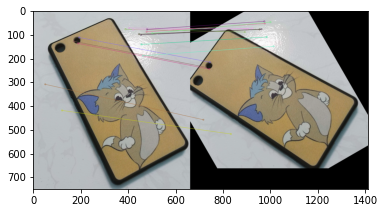

In [87]:
sp_matches, sp_keypointcv_1, sp_keypointcv_2, sp_imgmatch = superpointmatching(img1, img2, view = True)

#### compare function

In [94]:
def superpointvssiftperpes(img1, degree, viewmatch = True, viewperpes = True, viewmatrix = True):
  classtest = RotateMatrix2D(img1, degree = degree)
  img2 = classtest.rotateImage(viewMatrixRotate = False)

  # def rotateImage(self, degree = 0, viewMatrixRotate = False):
  # def sift(self, img1, img2, view = True):
  # def siftKeypointCoord(self, siftResult, numberCheckExample = 0):
  # def findMatrixRotateSIFT(self, image1, image2, view = True):
  # def findMatrixRotate(self, image, list_kp1, list_kp2, view = True):
  # def superpointmatching(img1, img2, view = False):

  sp_matches, sp_keypointcv_1, sp_keypointcv_2, sp_imgmatch = superpointmatching(img1, img2, view = False)
  sp_siftResult = [sp_matches, sp_keypointcv_1, sp_keypointcv_2]
  sp_keypoints_1, sp_keypoints_2 = classtest.siftKeypointCoord(sp_siftResult)
  sp_matrixrotate, sp_imgperpes = classtest.findMatrixRotate(img2, sp_keypoints_1, sp_keypoints_2, view = "notview")

  si_matches, si_keypoints_1, si_keypoints_2, si_imgmatch = classtest.sift(img1, img2, view = False)
  si_matrixrotate, si_imgperpes = classtest.findMatrixRotateSIFT(img1, img2, view = "notview")

  if viewmatch == True:
    plt.figure(figsize=(20, 5))
    plt.subplot(121), plt.imshow(sp_imgmatch)
    plt.title("Superpoint matching"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(si_imgmatch)
    plt.title("SIFT matching"), plt.xticks([]), plt.yticks([])
    plt.show()
  
  if viewperpes == True:
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(sp_imgperpes)
    plt.title("Superpoint 4p-perpestive"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(si_imgperpes)
    plt.title("SIFT 4p-perpestive"), plt.xticks([]), plt.yticks([])
    plt.show()

  if viewmatrix == True:
    print(" Superpoint matrix homogarphy-rotate:")
    print(sp_matrixrotate)
    print("SIFT matrix homogarphy-rotate:")
    print(si_matrixrotate)

### Compare result

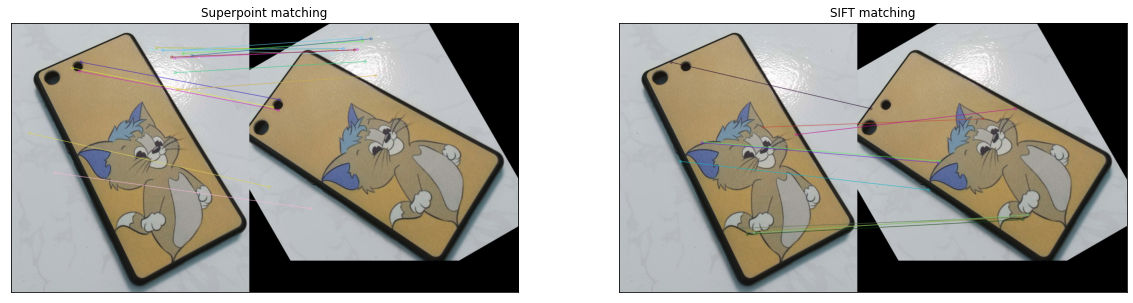

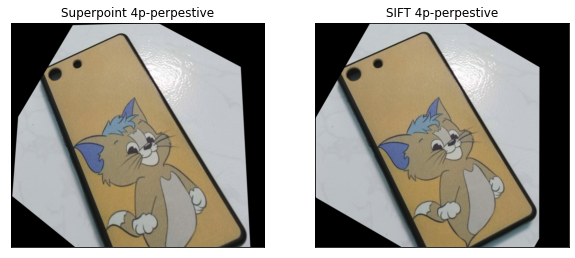

 Superpoint matrix homogarphy-rotate:
[[ 6.93093546e-01 -4.85624530e-01  2.45364767e+02]
 [ 4.26282601e-01  7.93217051e-01 -9.64544376e+01]
 [-2.61168093e-04 -5.92261418e-05  1.00000000e+00]]
SIFT matrix homogarphy-rotate:
[[ 8.70016661e-01 -5.00706016e-01  2.31782730e+02]
 [ 5.04844103e-01  8.69918253e-01 -1.17207895e+02]
 [ 6.48128861e-06  2.28892268e-06  1.00000000e+00]]


In [95]:
superpointvssiftperpes(img1, 30, viewmatch = True, viewperpes = True, viewmatrix = True)